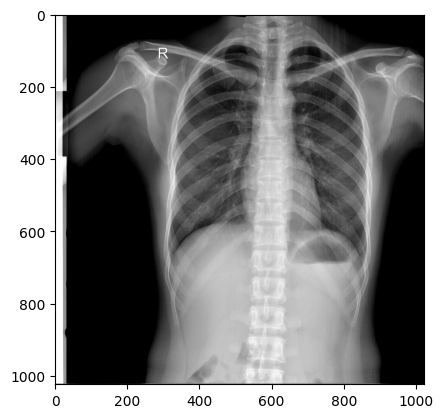

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install torcheval --quiet
!pip install torchxrayvision --quiet
!pip install pycocotools --quiet

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import torch 
import torchvision
import cv2
import matplotlib.pyplot as plt

root_path = Path("/kaggle/input/amia-public-challenge-2024")
img = cv2.imread(str(root_path / "train/train/00JgsY3R0C6VQrT7VDFcoqW2J7dOfULr.png"), 0)
img
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from scipy import stats 
stats.describe(img.flatten())

DescribeResult(nobs=1048576, minmax=(0, 255), mean=93.09384727478027, variance=5716.175982514438, skewness=0.19330046353736843, kurtosis=-1.1984942683938915)

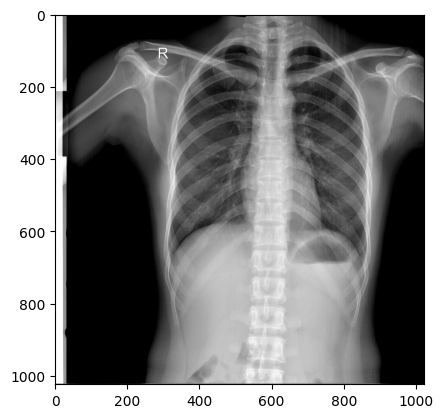

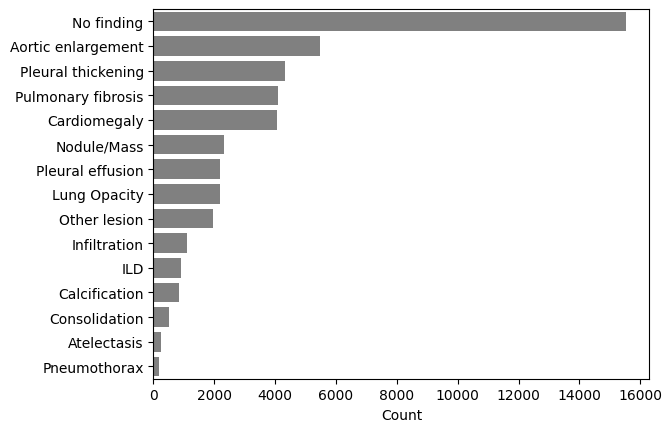

In [3]:
# normalize one image
norm = cv2.normalize(img, None, alpha=0, beta=1,
                     norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(norm, cmap='gray')
plt.show()

# Class imbalance? 
import pandas as pd
import seaborn as sns

df = pd.read_csv(root_path / "train.csv")
counts = df['class_name'].value_counts()

sns.barplot(y=counts.index, x=counts.values, color="gray")
plt.xlabel("Count")
plt.ylabel("")
plt.show()



Bounding box width statistics:
Mean: 50.91, Std: 59.83, Min: 0.13, Max: 428.83

Bounding box height statistics:
Mean: 40.73, Std: 51.06, Min: 0.13, Max: 439.21


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


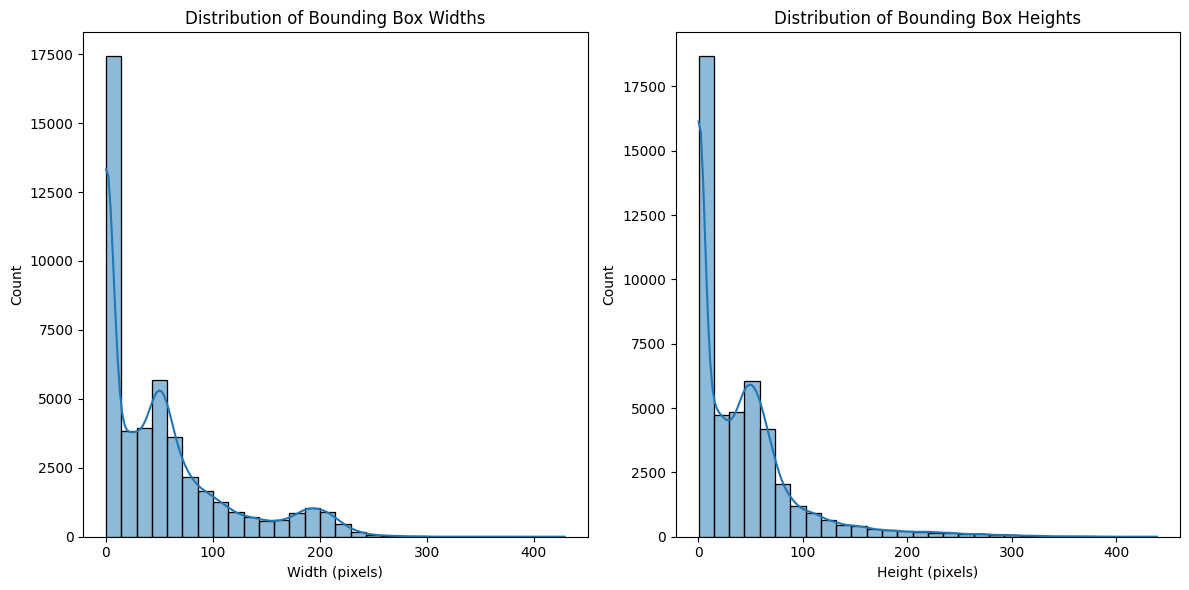

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


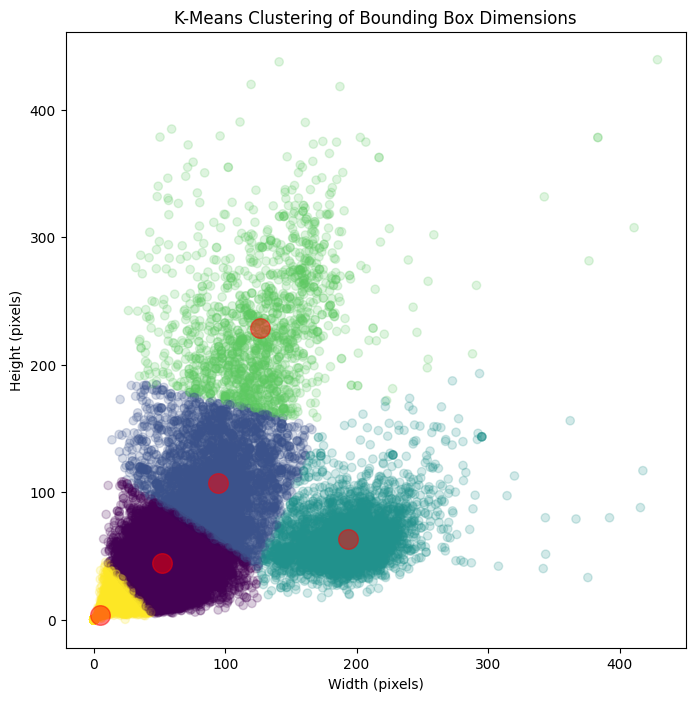


Suggested anchor sizes (width x height):
52 x 44
94 x 107
193 x 63
126 x 229
4 x 4

Aspect ratios:
[0.8530766095777425, 1.1318624057576578, 0.32945218825911154, 1.813018802199261, 0.8965419750065988]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 


# Load the CSV file
dict_path = "/kaggle/input/supplements/image_dict.json"

with open(dict_path) as f:
    data = json.load(f)

box_widths = []
box_heights = []

# Iterate over each image in the dictionary
for image_id, image_data in data.items():
    original_width, original_height = image_data["og_dims"]
    
    # Iterate over each class
    for class_id, radiologists in image_data["classes"].items():
        if class_id == 14: # ignore no findings
            continue
        # Iterate over each radiologist's annotations
        for rad_id, boxes in radiologists.items():
            for box in boxes:
                x_min, y_min, x_max, y_max = box
                
                # Convert relative coordinates to absolute pixel values
                box_width = (x_max - x_min) * 448 # targeted image size for training
                box_height = (y_max - y_min) * 448 
                
                # Append the width and height to the respective lists
                box_widths.append(box_width)
                box_heights.append(box_height)

box_widths = np.array(box_widths)
box_heights = np.array(box_heights)

# Print basic statistics
print("Bounding box width statistics:")
print(f"Mean: {box_widths.mean():.2f}, Std: {box_widths.std():.2f}, Min: {box_widths.min():.2f}, Max: {box_widths.max():.2f}")

print("\nBounding box height statistics:")
print(f"Mean: {box_heights.mean():.2f}, Std: {box_heights.std():.2f}, Min: {box_heights.min():.2f}, Max: {box_heights.max():.2f}")

# Plot the distribution of box sizes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(box_widths, bins=30, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(box_heights, bins=30, kde=True)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

# Calculate anchor box suggestions using k-means clustering
from sklearn.cluster import KMeans
box_dimensions = np.column_stack((box_widths, box_heights))
num_anchors = 5  # Number of anchors to suggest
kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(box_dimensions)

# plot the clusters
plt.figure(figsize=(8, 8))
plt.scatter(box_widths, box_heights, c=kmeans.labels_, cmap="viridis", alpha=0.2)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", s=200, alpha=0.5)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("K-Means Clustering of Bounding Box Dimensions")
plt.show()

# Output the cluster centers as suggested anchor sizes
print("\nSuggested anchor sizes (width x height):")
for anchor_size in kmeans.cluster_centers_:
    print(f"{int(anchor_size[0])} x {int(anchor_size[1])}")
print("\nAspect ratios:") 
print([height/width for width, height in kmeans.cluster_centers_])

In [5]:
import torch
import torchvision

# Initialize the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", trainable_backbone_layers=5)

# Define a dummy input image of size 448x448
dummy_image = torch.randn(1, 3, 448, 448)  # (batch_size, channels, height, width)

# Forward pass through the model to get feature maps
model.eval()
with torch.no_grad():
    # Extract feature maps for the RPN
    fpn_features = model(dummy_image)

# Convert features to a list as expected by the AnchorGenerator
fpn_features


[{'boxes': tensor([[375.4692, 443.6968, 399.9536, 447.8333],
          [380.7787, 444.0578, 411.7752, 447.9855],
          [ 30.4953, 444.2602,  64.5645, 447.9883],
          [116.7130, 444.1860, 159.8667, 448.0000],
          [116.6012, 444.2192, 159.9369, 448.0000],
          [135.4936, 444.2029, 187.4148, 447.9740],
          [202.4364, 444.0653, 239.6233, 447.9729],
          [135.5565, 444.1124, 187.4576, 448.0000],
          [343.5546, 443.6905, 386.6208, 447.9821],
          [135.5988, 444.1491, 187.4945, 447.9865],
          [263.5905, 443.7821, 303.2799, 447.8988],
          [394.1931, 443.9465, 421.1724, 447.8853],
          [ 93.1393, 443.8268, 138.0607, 447.9726],
          [ 92.9563, 443.7867, 138.3699, 447.9990],
          [234.8008, 444.2035, 277.2621, 447.9839],
          [394.1050, 443.8872, 421.3325, 447.9024],
          [235.0711, 444.1466, 277.1755, 447.9854],
          [116.8323, 444.2178, 159.7494, 447.9693],
          [ 30.4073, 444.2179,  64.7412, 447.9985],
   

In [26]:
import os
import numpy as np
import time
from tqdm.autonotebook import tqdm as tqdm
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms, tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2
import torchxrayvision as xrv

# import medmnist
# from medmnist import ChestMNIST, DermaMNIST, INFO, Evaluator
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.optim import lr_scheduler, SGD
from tqdm.autonotebook import tqdm
from torcheval.metrics.functional import multiclass_confusion_matrix
from torchinfo import summary
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import json

import torch.nn.functional as F
from torchvision.transforms.v2 import functional as F2
import torch.utils.data as data
import torchvision.transforms as transforms

import torch.optim as optim


import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, rpn
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt

import random, warnings


# --------------- Constants ------------------

ROOT = "/kaggle/input/amia-public-challenge-2024/"
# call augment data function
pic_folder_path = ROOT + "train/train"
inf_folder_path = ROOT + "test"
dict_path = "/kaggle/input/supplements/image_dict.json"
batch_size = 10

class_names = {
    0: "Aortic enlargement",
    1: "Atelectasis",
    2: "Calcification",
    3: "Cardiomegaly",
    4: "Consolidation",
    5: "ILD",
    6: "Infiltration",
    7: "Lung Opacity",
    8: "Nodule/Mass",
    9: "Other lesion",
    10: "Pleural effusion",
    11: "Pleural thickening",
    12: "Pneumothorax",
    13: "Pulmonary fibrosis",
    14: "No finding",
}

label_mapping = {
    "14": 0,  # 'No finding' mapped to 0 (background class)
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5,
    "5": 6,
    "6": 7,
    "7": 8,
    "8": 9,
    "9": 10,
    "10": 11,
    "11": 12,
    "12": 13,
    "13": 14,
}


# Detect OS and set num_workers accordingly
if os.name == "nt":  # Windows
    num_workers = 0
else:  # Linux and others
    num_workers = 2


# --------------- Helper functions ------------------
# Custom collate function to handle varying sizes of bounding boxes
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, targets


def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        warnings.warn("CUDA not available. Using CPU instead.", UserWarning)
    print("Device set to {}.".format(device))
    return device


# set seeds for reproducibility
def set_seeds(seed=123420):
    random.seed(seed)
    np.random.seed(seed + 1)
    torch.random.manual_seed(seed + 2)
    device = get_device()
    if device == "cuda":
        torch.cuda.manual_seed(seed + 3)
        torch.cuda.manual_seed_all(seed + 4)
        torch.backends.cudnn.deterministic = True
    print("Seeds set to {}.".format(seed))
    return


def string_to_tensor(s):
    return torch.tensor([ord(c) for c in s], dtype=torch.int64)


def tensor_to_string(t):
    return "".join([chr(c) for c in t])


class GrayscaleImageListDataset(Dataset):
    def __init__(self, img_dir, img_list, transform=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image


def get_mean_and_std(
    img_dir, img_list, batch_size=32, print_values=False, leave_pbar=False
):
    """
    Compute the mean and std color values of all images (grayscale values) in the specified list.

    Parameters:
    - img_dir (str): Directory containing the images.
    - img_list (list): List of image filenames to include in the calculation.
    - batch_size (int): Batch size for processing images.
    - print_values (bool): Whether to print the mean and std values.
    - leave_pbar (bool): Whether to leave the progress bar after completion.

    Returns:
    - mean (torch.Tensor): Mean grayscale values.
    - std (torch.Tensor): Standard deviation of grayscale values.
    """
    device = get_device()
    transform = transforms.ToTensor()
    dataset = GrayscaleImageListDataset(img_dir, img_list, transform=transform)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
    )

    channels_sum = torch.zeros(1).to(device)
    channels_squared_sum = torch.zeros(1).to(device)
    num_pixels = 0

    for images in tqdm(
        dataloader,
        desc="Calculating mean and std of all grayscale values",
        leave=leave_pbar,
        colour="CYAN",
    ):
        images = images.to(device)
        non_black_pixels = images[images != 0].view(-1)
        num_pixels += non_black_pixels.shape[0]

        channels_sum += torch.sum(non_black_pixels)
        channels_squared_sum += torch.sum(non_black_pixels**2)

    mean = channels_sum / num_pixels
    std = (channels_squared_sum / num_pixels - mean**2) ** 0.5

    if print_values:
        print(
            "Mean: ", mean.cpu().detach().numpy(), ", Std: ", std.cpu().detach().numpy()
        )

    return mean, std


# --------------- Data Loader ------------------
class XRayImageDataset(Dataset):
    """
    load image and targets from dict
    structure of the dict
        img_id: {
            "classes": [
                class_id: [
                rad_id: [[bbox],[bbox]]]
    """

    def __init__(
        self,
        dict,
        img_size,
        img_dir,
        mean=None,
        std=None,
        transform_norm=None,
        nms=True,
        nms_iou_thresh=0.5,
    ):
        self.dict = dict
        self.keys = list(dict.keys())
        self.img_size = img_size
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform_norm = transform_norm
        self.nms = nms
        self.nms_iou_thresh = nms_iou_thresh

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_id = self.keys[idx]
        img_path = os.path.join(self.img_dir, img_id) + ".png"

        image = read_image(img_path)

        box_list = []
        label_list = []
        area_list = []
        iscrowd_list = []
        for class_id in self.dict[img_id]["classes"]:
            if class_id == "14":
                continue
            # collect all boxes for the current class
            box = []
            for rad in self.dict[img_id]["classes"][class_id].items():
                for box in rad[1]:
                    # Ensure the box has 4 coordinates
                    if len(box) == 4 and box[2] > box[0] and box[3] > box[1]:
                        box_list.append([coord * image.shape[-1] for coord in box])
                        label_list.append(label_mapping[class_id])
                        area_list.append((box[2] - box[0]) * (box[3] - box[1]))
                        iscrowd_list.append(0)
                    else:
                        print(f"Invalid Box found at {img_id} with {box}")
            if self.nms:
                # Non-maximum suppression
                boxes_to_keep = torchvision.ops.nms(
                    torch.tensor(box_list).float(),
                    torch.tensor([1.0] * len(box_list)),
                    iou_threshold=self.nms_iou_thresh,
                )
                # now keep only the values of the indices that are in boxes_to_keep
                box_list = [box_list[i] for i in boxes_to_keep]
                label_list = [label_list[i] for i in boxes_to_keep]
                area_list = [area_list[i] for i in boxes_to_keep]
                iscrowd_list = [iscrowd_list[i] for i in boxes_to_keep]

        if len(box_list) > 0:
            boxes_tensor = tv_tensors.BoundingBoxes(
                box_list, format="XYXY", canvas_size=(image.shape[-1], image.shape[-1])
            )
        else:
            empty_boxes = np.array([]).reshape(-1, 4)
            boxes_tensor = torch.as_tensor(empty_boxes, dtype=torch.int16)
        labels_tensor = torch.tensor(label_list, dtype=torch.int64)
        areas_tensor = torch.tensor(area_list, dtype=torch.int32)
        iscrowd_tensor = torch.tensor(iscrowd_list, dtype=torch.uint8)

        if self.transform_norm:
            image, boxes_tensor = self.transform_norm(image, boxes_tensor)

        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": areas_tensor,
            "iscrowd": iscrowd_tensor,
            "filename": string_to_tensor(img_id),
        }

        return image, target


def load_and_augment_images(
    pic_folder_path,
    inf_folder_path,
    dict_path,
    batch_size,
    class_names,
    img_size=448,
    use_normalize=False,
):
    # split folders into 70% train and 30% test by ids
    set_seeds()
    train_percent = 0.01
    # Use the images in the ONE folder and split them into train and test
    train_ids = random.sample(
        os.listdir(pic_folder_path),
        int(train_percent * len(os.listdir(pic_folder_path))),
    )
    test_ids = [id for id in os.listdir(pic_folder_path) if id not in train_ids]

    # normalize on all train images or use precomputed
    if use_normalize:
        mean, std = get_mean_and_std(
            pic_folder_path, train_ids, print_values=True, leave_pbar=True
        )
        print("Mean: ", mean, ", Std: ", std)
    else:
        mean = 0.57062465
        std = 0.24919559

    # remove file extension
    train_ids = [id.split(".")[0] for id in train_ids]
    test_ids = [id.split(".")[0] for id in test_ids]
    # print first values and lengths
    print(f"Length of train_ids: {len(train_ids)}")
    print(f"Length of test_ids: {len(test_ids)}")

    # Data augmentation and normalization for training1
    data_transforms = {
        "train": v2.Compose(
            [
                v2.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                v2.Resize(img_size, antialias=True),
                v2.RandomRotation(
                    degrees=(-6, 6)
                ),  # all images are upright and will always be. No rotation needed? COuld be interesting to try for generalizing
                v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0),
                v2.ToDtype(torch.float32, scale=False),
                v2.RandomPerspective(distortion_scale=0.1, p=0.1),
                #v2.RandomEqualize(p=0.4),
                v2.Normalize(mean=[mean], std=[std], inplace=True),
            ]
        ),
        "test": v2.Compose(
            [
                v2.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                v2.Resize(img_size, antialias=True),
                v2.ToTensor(),  # Convert PIL images to tensors
                v2.ToDtype(torch.float32, scale=False),
                # Equalize all images to have a more uniform distribution of pixel intensities, regardless of they are generally dark or light
                #v2.RandomEqualize(p=1.0),
                v2.Normalize(mean=[mean], std=[std], inplace=True),
            ]
        ),
    }

    # load image_dict.json
    with open(dict_path) as f:
        og_dict = json.load(f)

    # train_dict where keys match train_ids
    train_dict = {
        k: og_dict[k] for k in train_ids}# if "14" not in og_dict[k]["classes"]}
    #print("Remaining train dict length: ", len(train_dict))
    test_dict = {
        k: og_dict[k] for k in test_ids}# if "14" not in og_dict[k]["classes"]}
    #print("Remaining test dict length: ", len(test_dict))

    # size for images
    img_size = img_size
    train_dataset = XRayImageDataset(
        train_dict, img_size, pic_folder_path, mean, std, data_transforms["train"]
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    test_dataset = XRayImageDataset(
        test_dict, img_size, pic_folder_path, mean, std, data_transforms["test"]
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # no need for batches
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    # image folder
    inference_dataset = datasets.ImageFolder(
        root=inf_folder_path, transform=data_transforms["test"]
    )

    inference_dataloader = torch.utils.data.DataLoader(
        inference_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    print("Loaded the training dataset.")

    dataloaders = {"train": train_dataloader, "test": test_dataloader, "inference": inference_dataloader}

    num_classes = class_names.items().__len__()

    return dataloaders, class_names, num_classes


# --------------- Model ------------------

# considering the bboxes of the k-means analysis, we chose the following anchors at each level. one large, one small, one intermediate. 
anchor_generator = rpn.AnchorGenerator(
   sizes=((10,), (60,), (200,))*5, # times 5 'cause we want all sizes on all layers 
   aspect_ratios=((0.3, 1.0, 1.5),)*5, # times 5 'cause 5 feature maps'
)

# old 
'''anchor_generator = rpn.AnchorGenerator(
    sizes=((32,), (48,), (64,), (96,), (128,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)'''


model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", trainable_backbone_layers=5)

# use pre-trained on chest x-rays
backbone = xrv.models.ResNet(weights="resnet50-res512-all")
#backbone = torchvision.models.resnet34(pretrained=True, norm_layer=torchvision.ops.FrozenBatchNorm2d)
backbone = torch.nn.Sequential(*list(backbone.model.children())[:-2])
#backbone.out_channels = 2048

# Define the layers to return feature maps from
return_layers = {
    '4': '0',  # Corresponds to layer1
    '5': '1',  # Corresponds to layer2
    '6': '2',  # Corresponds to layer3
    '7': '3',  # Corresponds to layer4
}

# Construct the BackboneWithFPN
backbone_with_fpn = BackboneWithFPN(
    backbone,
    return_layers=return_layers,  # The layers we want to use
    in_channels_list=[256, 512, 1024, 2048],  # Corresponding in_channels for these layers
    out_channels=256  # Out channels for FPN layers
)

roi_align = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3', '4'], output_size=7, sampling_ratio=2)

model = torchvision.models.detection.FasterRCNN(
    backbone_with_fpn,
    num_classes=15,
    #min_size=448, # produces NaN losses
    #max_size=448,
    image_mean=[0.57062465], # prevent ImageNet normalizing
    image_std=[0.24919559],
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_align,
    box_batch_size_per_image=128,
    #rpn_pre_nms_top_n_train=2000,
    #rpn_post_nms_top_n_test=1000,
    #rpn_post_nms_top_n_train=2000,
    #rpn_post_nms_top_n_test=1000,
    #rpn_nms_thresh=0.7, # lower NMS -> fewer proposals
    #box_score_thresh=0.5, # increase to filter low-confidence detections
    #box_detections_per_img=69, # default 100 -> overkill?
)

def plot_img_bbox(img, target, pred, title):
    # plot the image and bboxes
    # different colors for target and pred
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    img = img.cpu().permute(1, 2, 0)
    ax.imshow(img, cmap="gray")
    for box in target["boxes"]:
        box = box.cpu().numpy()
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)
    for box in pred["boxes"]:
        box = box.cpu().numpy()
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    ax.set_title(title)
    # plt.savefig(f"{title}.png")




def train_and_evaluate(model, train_dataloader, val_dataloader, num_epochs=30, lr=0.005):
    set_seeds()
    torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    device = get_device()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    # optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.Adamax(params, lr=lr, weight_decay=0.00005)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # let's try this one as well

    # Initialize MeanAveragePrecision metric
    metric = MeanAveragePrecision(
        box_format="xyxy",
        iou_type="bbox",
        iou_thresholds=[0.1, 0.4, 0.7],
    )
    best_map={"map": 0.0}

    print("Starting the training...")

    scaler = torch.cuda.amp.GradScaler()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        loss_dict = {}
        for images, targets in tqdm(
            train_dataloader, desc="Training", leave=True, colour="BLUE"
        ):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            found_invalid_box = False
            # check if the targets(bounding boxes) are smaller than the image size and have the correct format (positive width and height)
            for target in targets:
                for box in target["boxes"]:
                    if box[2] <= box[0] or box[3] <= box[1]:
                        found_invalid_box = True
                        print(f"Invalid Box found in training with {box}")
                    if box[2] > images[0].shape[-1] or box[3] > images[0].shape[-2]:
                        found_invalid_box = True
                        print(f"Box outside of image found in training with {box}")
                if found_invalid_box:
                    print(f"Image: {tensor_to_string(target['filename'])}")
                    #raise ValueError("Invalid box found in training data")

            #if len(targets[0]["boxes"]>0):
             #   plot_img_bbox(
              #      images[0],
               #     targets[0],
                #    {"boxes": []},
                 #   f"Image {tensor_to_string(target['filename'])}",
                #)
                
            # Apply mixed precision training
            with torch.cuda.amp.autocast():
                # when training the fasterrcnn model, the model returns a dict with losses.
                # include class weights in the losses to balance the classes
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()
            optimizer.zero_grad()
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        lr_scheduler.step()  # TODO: adjust scheduler

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
        print(loss_dict)
        
        model.eval()
        with torch.no_grad():
            for images, targets in tqdm(
                val_dataloader, desc="Validation", leave=True, colour="GREEN"
            ):
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                predictions = model(images)

                filtered_predictions = []
                filtered_targets = []

                # check if image gets predictions and plot
                for img, target, pred in zip(images, targets, predictions):
                    #print("target:", target)
                    #print("pred:", pred)
                    if len(target["boxes"])>0:
                        #plot_img_bbox(
                        #    img,
                        #    target,
                        #    pred,
                        #    f"Image {tensor_to_string(target['filename'])}",
                        #)
                        #return
                        filtered_predictions.append(pred)
                        filtered_targets.append(target)
                    elif (len(pred["boxes"]) == 0) and (len(target["boxes"]) == 0):
                        # append 1-pixel boxes
                        filtered_predictions.append(
                            {
                                "boxes": torch.tensor([[0, 0, 1, 1]]).to(device),
                                "scores": torch.tensor([1.]).to(device),
                                "labels": torch.tensor([0]).to(device),
                            }
                        )
                        filtered_targets.append(
                            {
                                "boxes": torch.tensor([[0, 0, 1, 1]]).to(device),
                                "scores": torch.tensor([1.]).to(device),
                                "labels": torch.tensor([0]).to(device),
                            }
                        )

                # Calculate metrics
                # if len(filtered_predictions) > 0:
                metric.update(filtered_predictions, filtered_targets)
                #     print(f"Filtered Outputs: {filtered_predictions}")
                #     print(f"Filtered Targets: {filtered_targets}")

        # Calculate and print the mAP
        map_metric = metric.compute()
        print(f"Epoch [{epoch+1}/{num_epochs}], Val mAP: {map_metric['map']:.4f}")
        print(map_metric)
        if map_metric["map"] >= best_map["map"]:
            torch.save(model,'fasterrcnn_try3.pt')
            
        # Reset the metric for the next epoch
        metric.reset()
    print("Finished Training!")
    
def evaluate_and_create_csv(model, test_dataloader, device):
    model.to(device)
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, image_ids in test_dataloader:
            images = [image.to(device) for image in images]
            outputs = model(images)
            
            for image_id, output in tqdm(zip(image_ids, outputs),desc="Writing Predictions to CSV",leave=True):
                boxes = output['boxes'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                
                row = [str(image_id)]
                if len(boxes) > 0:
                    targets = []
                    for box, label, score in zip(boxes, labels, scores):
                        # Ensure the bounding box coordinates are integers
                        box = [int(b) for b in box]
                        # switch class back to AMIA format
                        targets.append(f"{int(label)-1} {score:.2f} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}")
                    row.append(" ".join(targets))
                else:
                    # no boxes -> class 14 'No finding'
                    row.append("14 1 0 0 1 1")
                
                results.append(",".join(row)) # image_id, [class score box] [...]
    
    # Incorporate unix timestamp into the filename
    output_csv_path = f'submission_{int(time.time())}.csv'
    with open(output_csv_path, 'w') as f:
        f.write("ID,TARGET\n") # header row
        for result in results:
            f.write(f"{result}\n")
        print("All predictions written!")

In [19]:
# --------------- Main ------------------

dataloaders, class_names, num_classes = load_and_augment_images(
    pic_folder_path, inf_folder_path, dict_path, batch_size, class_names
)

Device set to cuda.
Seeds set to 123420.
Length of train_ids: 85
Length of test_ids: 8488
Loaded the training dataset.


In [ ]:
train_and_evaluate(model, dataloaders["train"], dataloaders["test"], 2)

In [27]:
evaluate_and_create_csv(model, dataloaders["inference"], get_device())

Device set to cuda.


Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

Writing Predictions to CSV: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
#model
#print(torch.__version__)

In [ ]:
torch.save(model,'fasterrcnn_after_training.pt')